This notebook uses torchvision models as well as official reference helpers for object detection.

# Setting up environment

In [2]:
%%capture
!pip install aicrowd-cli

%load_ext aicrowd.magic


## Login to AIcrowd


In [ ]:
%aicrowd login

Please login here: https://api.aicrowd.com/auth/fV7W-eU6AHcvBF-nDKdKA9yvfqkiaWOP2b5vBT0Lfl4



## Download Dataset

We will create a folder name data and download the files there.


In [ ]:
!rm -rf data
!mkdir data
%aicrowd ds dl -c mask-prediction -o data

sample_submission.csv:   0%|          | 0.00/44.0k [00:00<?, ?B/s]

test.zip:   0%|          | 0.00/115M [00:00<?, ?B/s]

train.csv:   0%|          | 0.00/193k [00:00<?, ?B/s]

train.zip:   0%|          | 0.00/318M [00:00<?, ?B/s]

val.csv:   0%|          | 0.00/82.8k [00:00<?, ?B/s]

val.zip:   0%|          | 0.00/137M [00:00<?, ?B/s]

In [1]:
!unzip data/train.zip -d data/ > /dev/null
!unzip data/val.zip -d data/ > /dev/null
!unzip data/test.zip -d data/ > /dev/null

# Importing Libraries

In [13]:
import os
import numpy as np
import torch
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import torchvision

import transforms as T
from engine import train_one_epoch, evaluate
import utils
import albumentations as A

# Creating helper classes

In [41]:
class MaskDataset(torch.utils.data.Dataset):
    def __init__(self, root, class_df, transforms):
        self.root = root
        self.transforms = transforms
        self.classes = ["cloth", "KN95","N95", "surgical"]
        self.class_df = class_df
    def __getitem__(self, idx):
        # load images
        img_path = os.path.join(self.root, (self.class_df["ImageID"][idx]+".jpg"))
        img = Image.open(img_path).convert("RGB")
        # get bounding boxes and class
        if isinstance(self.class_df["masktype"][idx], str):
            labels = self.classes.index(self.class_df["masktype"][idx]) + 1 # because background
        else:
            labels = 0 # should not occur
        labels = np.array([labels])
        labels = torch.as_tensor(labels, dtype=torch.int64)
        if isinstance(self.class_df["bbox"][idx], list):
            boxes = self.class_df["bbox"][idx]
        else:
            boxes = eval(self.class_df["bbox"][idx])
        boxes = np.array(boxes)
        boxes = np.expand_dims(boxes, axis=0)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)
        iscrowd = torch.zeros((1,), dtype=torch.int64)
        
        # PIL to np array
        if self.transforms is not None:
            img = np.array(img)
            transformed = self.transforms(image=img, bboxes=boxes, class_labels = labels)
            img, boxes, _ = transformed['image'], transformed['bboxes'], transformed['class_labels']
            img = Image.fromarray(img)
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        
        img, target = T.ToTensor()(img, target)

        return img, target
    
    def __len__(self):
        return self.class_df.shape[0]

In [15]:
class TestMaskDataset(torch.utils.data.Dataset):
    def __init__(self, root, class_df, transforms):
        self.root = root
        self.transforms = transforms
        self.class_df = class_df
    def __getitem__(self, idx):
        # load images
        img_path = os.path.join(self.root, (self.class_df["ImageID"][idx]+".jpg"))
        img = Image.open(img_path).convert("RGB")
        if self.transforms is not None:
            img = self.transforms(img)
        return img
    
    def __len__(self):
        return self.class_df.shape[0]

# Diving in the dataset

In [16]:
train_images = 'data/train'
val_images = 'data/val'
test_images = 'data/test'

In [17]:
classes = ["cloth", "KN95","N95", "surgical"]

In [18]:
train_df = pd.read_csv("data/train.csv")
val_df = pd.read_csv("data/val.csv")

In [19]:
train_df.head()

,ImageID,bbox,masktype
0,k8o0f,"[73, 197, 293, 400]",N95
1,7a0l9,"[47, 364, 300, 512]",surgical
2,wfp7p,"[203, 221, 380, 403]",N95
3,7qaw6,"[87, 210, 322, 385]",surgical
4,i4kqj,"[227, 283, 479, 475]",surgical


In [20]:
train_df['masktype'].value_counts()

cloth       1422
surgical    1397
KN95        1396
N95         1385
Name: masktype, dtype: int64

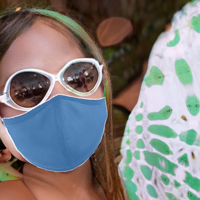

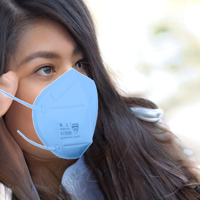

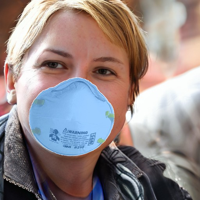

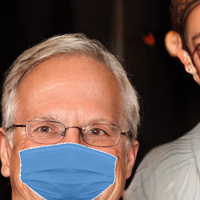

In [9]:
for masktype in classes:
    im = Image.open(os.path.join(train_images, (train_df["ImageID"][train_df[train_df["masktype"]==masktype].index[0]]+".jpg")))
    display(im.resize((200, 200)))

# Preprocessing

In [21]:
train_transform = A.Compose([
    A.augmentations.crops.transforms.RandomResizedCrop(512, 512, p=0.5),
    A.augmentations.geometric.transforms.Perspective(),
    A.augmentations.transforms.HorizontalFlip(),
    A.augmentations.geometric.transforms.ShiftScaleRotate(border_mode=0)], 
    bbox_params=A.BboxParams(format='pascal_voc', min_visibility=0.1, label_fields=["class_labels"]))

In [47]:
train_ds = MaskDataset(train_images, train_df, train_transform)
val_ds = MaskDataset(val_images, val_df, None)

# Model

In [19]:
def train(train_ds, val_ds, model):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    num_classes = 5
    # define training and validation data loaders
    train_loader = torch.utils.data.DataLoader(
        train_ds, batch_size=16, shuffle=True, num_workers=8,
        collate_fn=utils.collate_fn)

    val_loader = torch.utils.data.DataLoader(
        val_ds, batch_size=16, shuffle=False, num_workers=8,
        collate_fn=utils.collate_fn)
    
    # move model to the right device
    model.to(device)

    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)
    # and a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)
    num_epochs = 25

    for epoch in range(num_epochs):
        # train for one epoch, printing every 50 iterations
        train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=50)
        # update the learning rate
        lr_scheduler.step()
        # evaluate on the test dataset
        evaluate(model, val_loader, device=device)
        
    return model

In [20]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(num_classes=5)

In [ ]:
model = train(train_ds, val_ds, model)

In [35]:
torch.save(model.state_dict(), 'model_weights.pth')

# Results submission

In [79]:
test_df = pd.read_csv("data/sample_submission.csv")
test_df.head()

,ImageID,bbox,masktype
0,os9el,"[0, 0, 0, 0]",NaN
1,gksn6,"[0, 0, 0, 0]",NaN
2,odcws,"[0, 0, 0, 0]",NaN
3,04qsi,"[0, 0, 0, 0]",NaN
4,6canb,"[0, 0, 0, 0]",NaN


In [22]:
test_transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
test_ds = TestMaskDataset(test_images, test_df, test_transform)

In [23]:
test_loader = torch.utils.data.DataLoader(
        test_ds, batch_size=1, shuffle=False, num_workers=8)

In [11]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(num_classes=5)
model.load_state_dict(torch.load('model_weights.pth'))

<All keys matched successfully>

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
model.eval()

In [103]:
labels = []
boxes = []

In [104]:
for idx, img in enumerate(test_loader):
    img = img.to(device)
    res = model(img)
    if res[0]["scores"].shape[0] >= 1:
        box = res[0]['boxes'].cpu().detach().numpy()[0]
#         box = (box.astype(int)).tolist()
        box = box.tolist()
        label = int((res[0]["labels"].cpu().detach().numpy()[0]))
    else:
        label = ""
        box = [0, 0, 0, 0]
        
    labels.append(label)
    boxes.append(box)

In [106]:
newlist = [classes[label-1] if isinstance(label, int) else label for label in labels]

In [111]:
test_df["bbox"] = boxes

In [109]:
test_df["masktype"] = newlist

In [ ]:
test_df.head()

In [114]:
test_df.to_csv("submission.csv", index=False)